# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')

import yfinance as yf

## Description of the project:
- Take some set of stocks.
- Divide it into two groups:
    - High volatility
    - Low volatility
- For each of these groups find weights minimizing total volatility.

In [15]:
#downloading stocks
tickers = ['TSLA', 'NVDA', 'COIN', 'PLTR', 'ROKU', 'AMD', 'JNJ', 'PG', 'KO', 'VZ', 'WMT', 
           'MSFT', 'GOOGL', 'AAPL', 'HD', 'LOW', 'XOM', 'CVX', 'FCX', 'NEM', 'JPM', 'CAT',
          'ASML', 'TSM', 'BABA', 'SHOP', 'NVO', 'TM', 'SONY', 'BHP', 'UL',
          'NFLX',   'ZM',   'UBER',   'SPOT',   'BYND',   'MRNA', 'ARKK', 'RBLX',
          'NEE',   'MMM',   'MCD',   'DIS',   'PFE', 'T', 'QQQ']


start_date = dt.datetime.today()-dt.timedelta(days = 365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end =end_date)

close = stock['Close']
normalized_returns = close/close.iloc[0]-1

normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

stock = pd.concat([stock, normalized_returns], axis =1 )

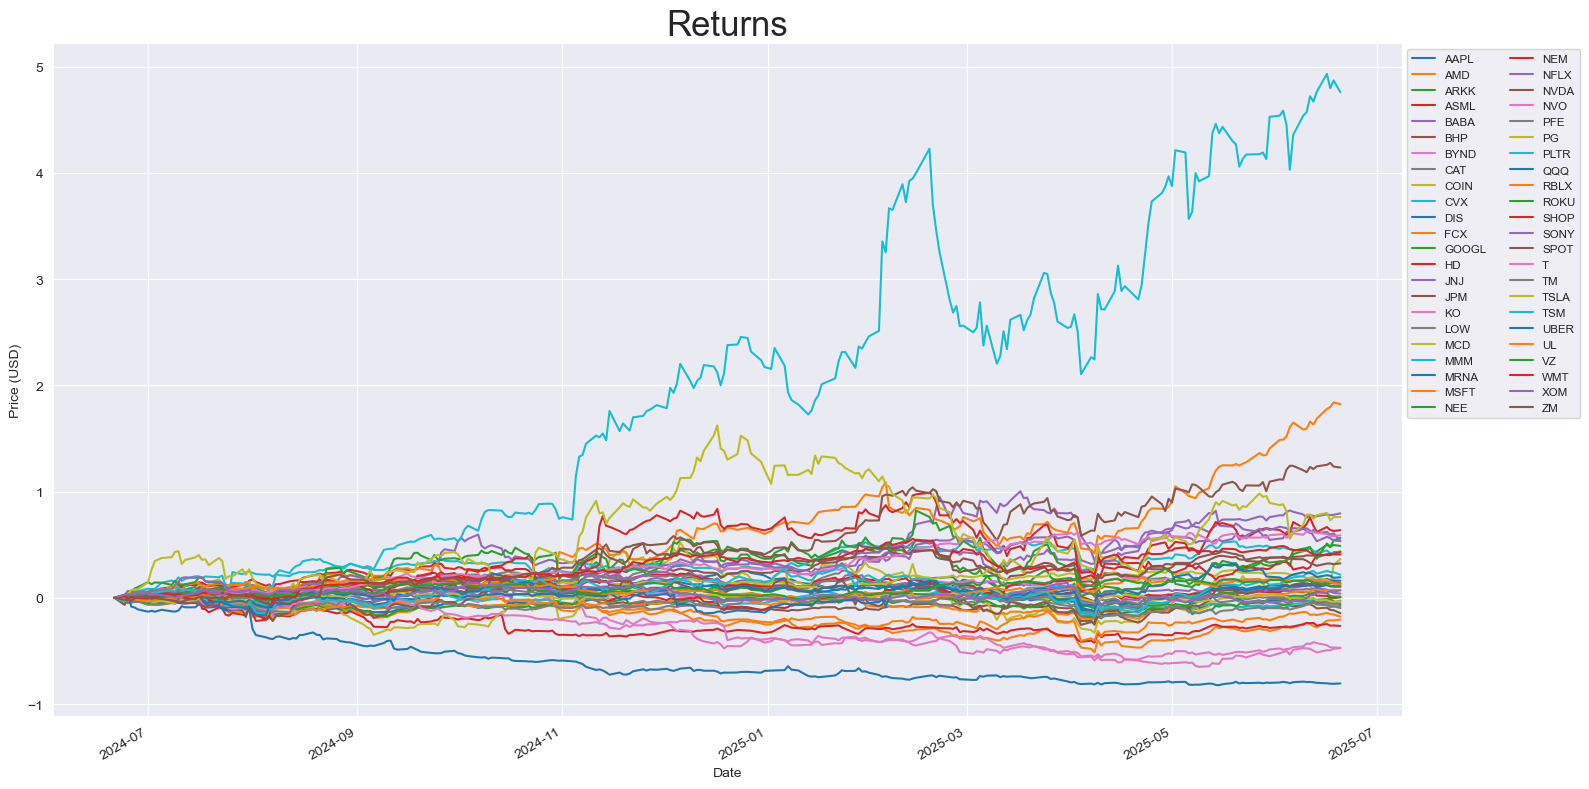

In [17]:
ax = stock['Cumulative Return'].plot(figsize=(16,8))
ax.set_title('Returns', fontsize=25)
ax.set_ylabel('Price (USD)')

# split legend into 2 columns, shrink font a bit
ax.legend(ncol=2, fontsize='small', loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

In [18]:
#computing daily log returns
daily_log_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_log_returns = daily_log_returns.dropna()


In [24]:
#Computing volatility 
volatility = daily_log_returns.std() * np.sqrt(252)

#Let's say that high volatility is > 0.5 and low volatility is < 0.3
high_volatility_tickers = volatility[volatility > 0.5].index.tolist()
print(f"stocks with volatility > 0.5 : {high_volatility_tickers}")

low_volatility_tickers = volatility[volatility < 0.3].index.tolist()
print(f"stocks with volatility < 0.3 : {low_volatility_tickers}")

stocks with volatility > 0.5 : ['AMD', 'BYND', 'COIN', 'MRNA', 'NVDA', 'PLTR', 'ROKU', 'SHOP', 'TSLA']
stocks with volatility < 0.3 : ['BHP', 'CVX', 'HD', 'JNJ', 'JPM', 'KO', 'LOW', 'MCD', 'MSFT', 'NEE', 'PFE', 'PG', 'QQQ', 'T', 'UL', 'VZ', 'WMT', 'XOM']


In [25]:
#computing covariance matrices for high and low volatility stocks
covariance_matrix = 252*((daily_log_returns).cov())
high_covariance_matrix = 252*((daily_log_returns[high_volatility_tickers]).cov())
low_covariance_matrix = 252*((daily_log_returns[low_volatility_tickers]).cov())

In [20]:
#We will try to find weights in each category minimizing volatility of each stock.

n_low = len(low_volatility_tickers)
n_high = len(high_volatility_tickers)

low_initial_weights = np.array([1/n_low] * n_low)
high_initial_weights = np.array([1/n_high] * n_high)

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1}, {'type': 'ineq', 'fun': lambda weights: min(weights)-.0})

def portfolio_volatility(weights, mat):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(mat, weights)))
    return portfolio_std_dev

low_res = minimize(portfolio_volatility, low_initial_weights, args=(low_covariance_matrix,), constraints=constraints)

low_optimal_weights = low_res.x

# Print the optimal weights and expected returns
print("Low risk:")
for ticker, weight in zip(low_volatility_tickers, low_optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")
    
print(f' The optimal volatility subject to the constraints is {low_res.fun}')
print("-----"*20)
print("-----"*20)


high_res = minimize(portfolio_volatility, high_initial_weights, args=(high_covariance_matrix,), constraints=constraints)

high_optimal_weights = high_res.x
print("High risk")
for ticker, weight in zip(high_volatility_tickers, high_optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")
    
print(f' The optimal volatility subject to the constraints is {high_res.fun}')
print("-----"*20)
print("-----"*20)


Low risk:
BHP: Weight = 0.0000
CVX: Weight = 0.0001
HD: Weight = 0.0360
JNJ: Weight = 0.1785
JPM: Weight = 0.0053
KO: Weight = 0.1657
LOW: Weight = 0.0017
MCD: Weight = 0.0688
MSFT: Weight = 0.2156
NEE: Weight = -0.0000
PFE: Weight = -0.0000
PG: Weight = 0.0380
T: Weight = 0.0598
UL: Weight = 0.1176
VZ: Weight = 0.0154
WMT: Weight = 0.0060
XOM: Weight = 0.0914
 The optimal volatility subject to the constraints is 0.1169374278598278
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
High risk
AMD: Weight = 0.2248
BYND: Weight = 0.1837
COIN: Weight = -0.0000
MRNA: Weight = 0.1608
NVDA: Weight = 0.1538
PLTR: Weight = 0.0490
ROKU: Weight = 0.1001
SHOP: Weight = 0.1128
TSLA: Weight = 0.0150
 The optimal volatility subject to the constraints is 0.42853009986011126
--------------------------------------------------------------------------------

Text(0.5, 1.0, 'Portfolio Performance Comparison')

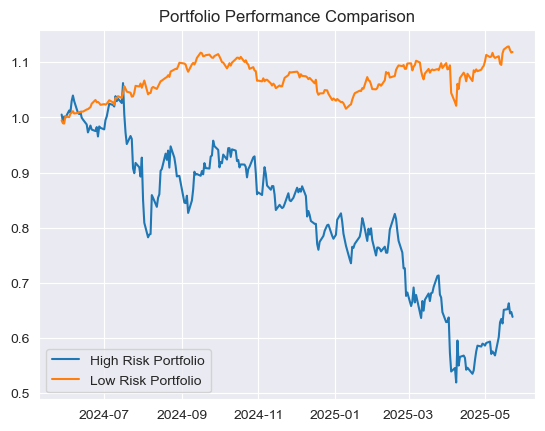

In [77]:
#In this cell we plot returns of the portfolios for the chosen period of time

portfolio_returns_high = (daily_log_returns[high_volatility_tickers] * high_optimal_weights).sum(axis=1)
portfolio_returns_low = (daily_log_returns[low_volatility_tickers] * low_optimal_weights).sum(axis=1)

# Plot cumulative performance
cumulative_high = (1 + portfolio_returns_high).cumprod()
cumulative_low = (1 + portfolio_returns_low).cumprod()

plt.plot(cumulative_high, label='High Risk Portfolio')
plt.plot(cumulative_low, label='Low Risk Portfolio')
plt.legend()
plt.title('Portfolio Performance Comparison')


In [22]:
high_optimal_weights

array([ 2.24815651e-01,  1.83678415e-01, -5.23127548e-18,  1.60836762e-01,
        1.53806898e-01,  4.90010100e-02,  1.00117558e-01,  1.12753954e-01,
        1.49897518e-02])

In [21]:
low_optimal_weights

array([ 4.40317353e-05,  1.41584898e-04,  3.60369068e-02,  1.78514373e-01,
        5.25038039e-03,  1.65721028e-01,  1.72225902e-03,  6.88259186e-02,
        2.15575441e-01, -1.12336572e-09, -4.63899270e-08,  3.79546024e-02,
        5.98487863e-02,  1.17594246e-01,  1.53775951e-02,  5.97310869e-03,
        9.14197860e-02])